## Code for training the noise model

Description of nm theory and why we need it

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from careamics import CAREamist
from careamics.models.lvae.noise_models import GaussianMixtureNoiseModel, create_histogram
from careamics.config import GaussianMixtureNMConfig
from careamics.config import create_n2v_configuration

import sys
sys.path.insert(0, "/home/igor.zubarev/projects/microSplit-reproducibility/")
from configs.data.pavia3 import get_data_configs
from datasets.pavia3 import get_train_val_data
from utils.utils import plot_probability_distribution



### Load and prepare data

Data preparation, dataset specific or load from function in this repo



In [3]:
train_data_config, val_data_config, test_data_config = get_data_configs()

In [4]:
input_data = get_train_val_data(data_config=train_data_config,
                                datadir="/localscratch/data/pavia3_sequential_cropped",
                                val_fraction=0.1)


Explicit datasplit Train [1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]
Loaded from SubDsetType.MultiChannel /localscratch/data/pavia3_sequential_cropped 13/17 frames


In [5]:
train_data = input_data._data[0].squeeze()

### Create N2V configuration

In [13]:
config = create_n2v_configuration(
    experiment_name="bla",
    data_type="array",
    axes="YXC",
    n_channels=2,
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=1,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 2,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 2},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YXC',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
    

### Train N2V 

In [14]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_data,
    val_minimum_split=5,
)

No working directory provided. Using current working directory: /home/igor.zubarev/projects/microSplit-reproducibility/submission_notebooks.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [112.29201595 125.43661035], std: [11.15737703 12.4600503 ]
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/igor.zubarev/projects/microSplit-reproducibility/submission_notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.0 M  | train
---------------------------------------
1.0 M   

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s, train_loss_step=0.643, val_loss=0.899, train_loss_epoch=0.914]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, train_loss_step=0.643, val_loss=0.899, train_loss_epoch=0.914]


In [15]:
predicition = careamist.predict(train_data, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 70/70 [00:00<00:00, 126.85it/s]


### Visualize N2V predictions

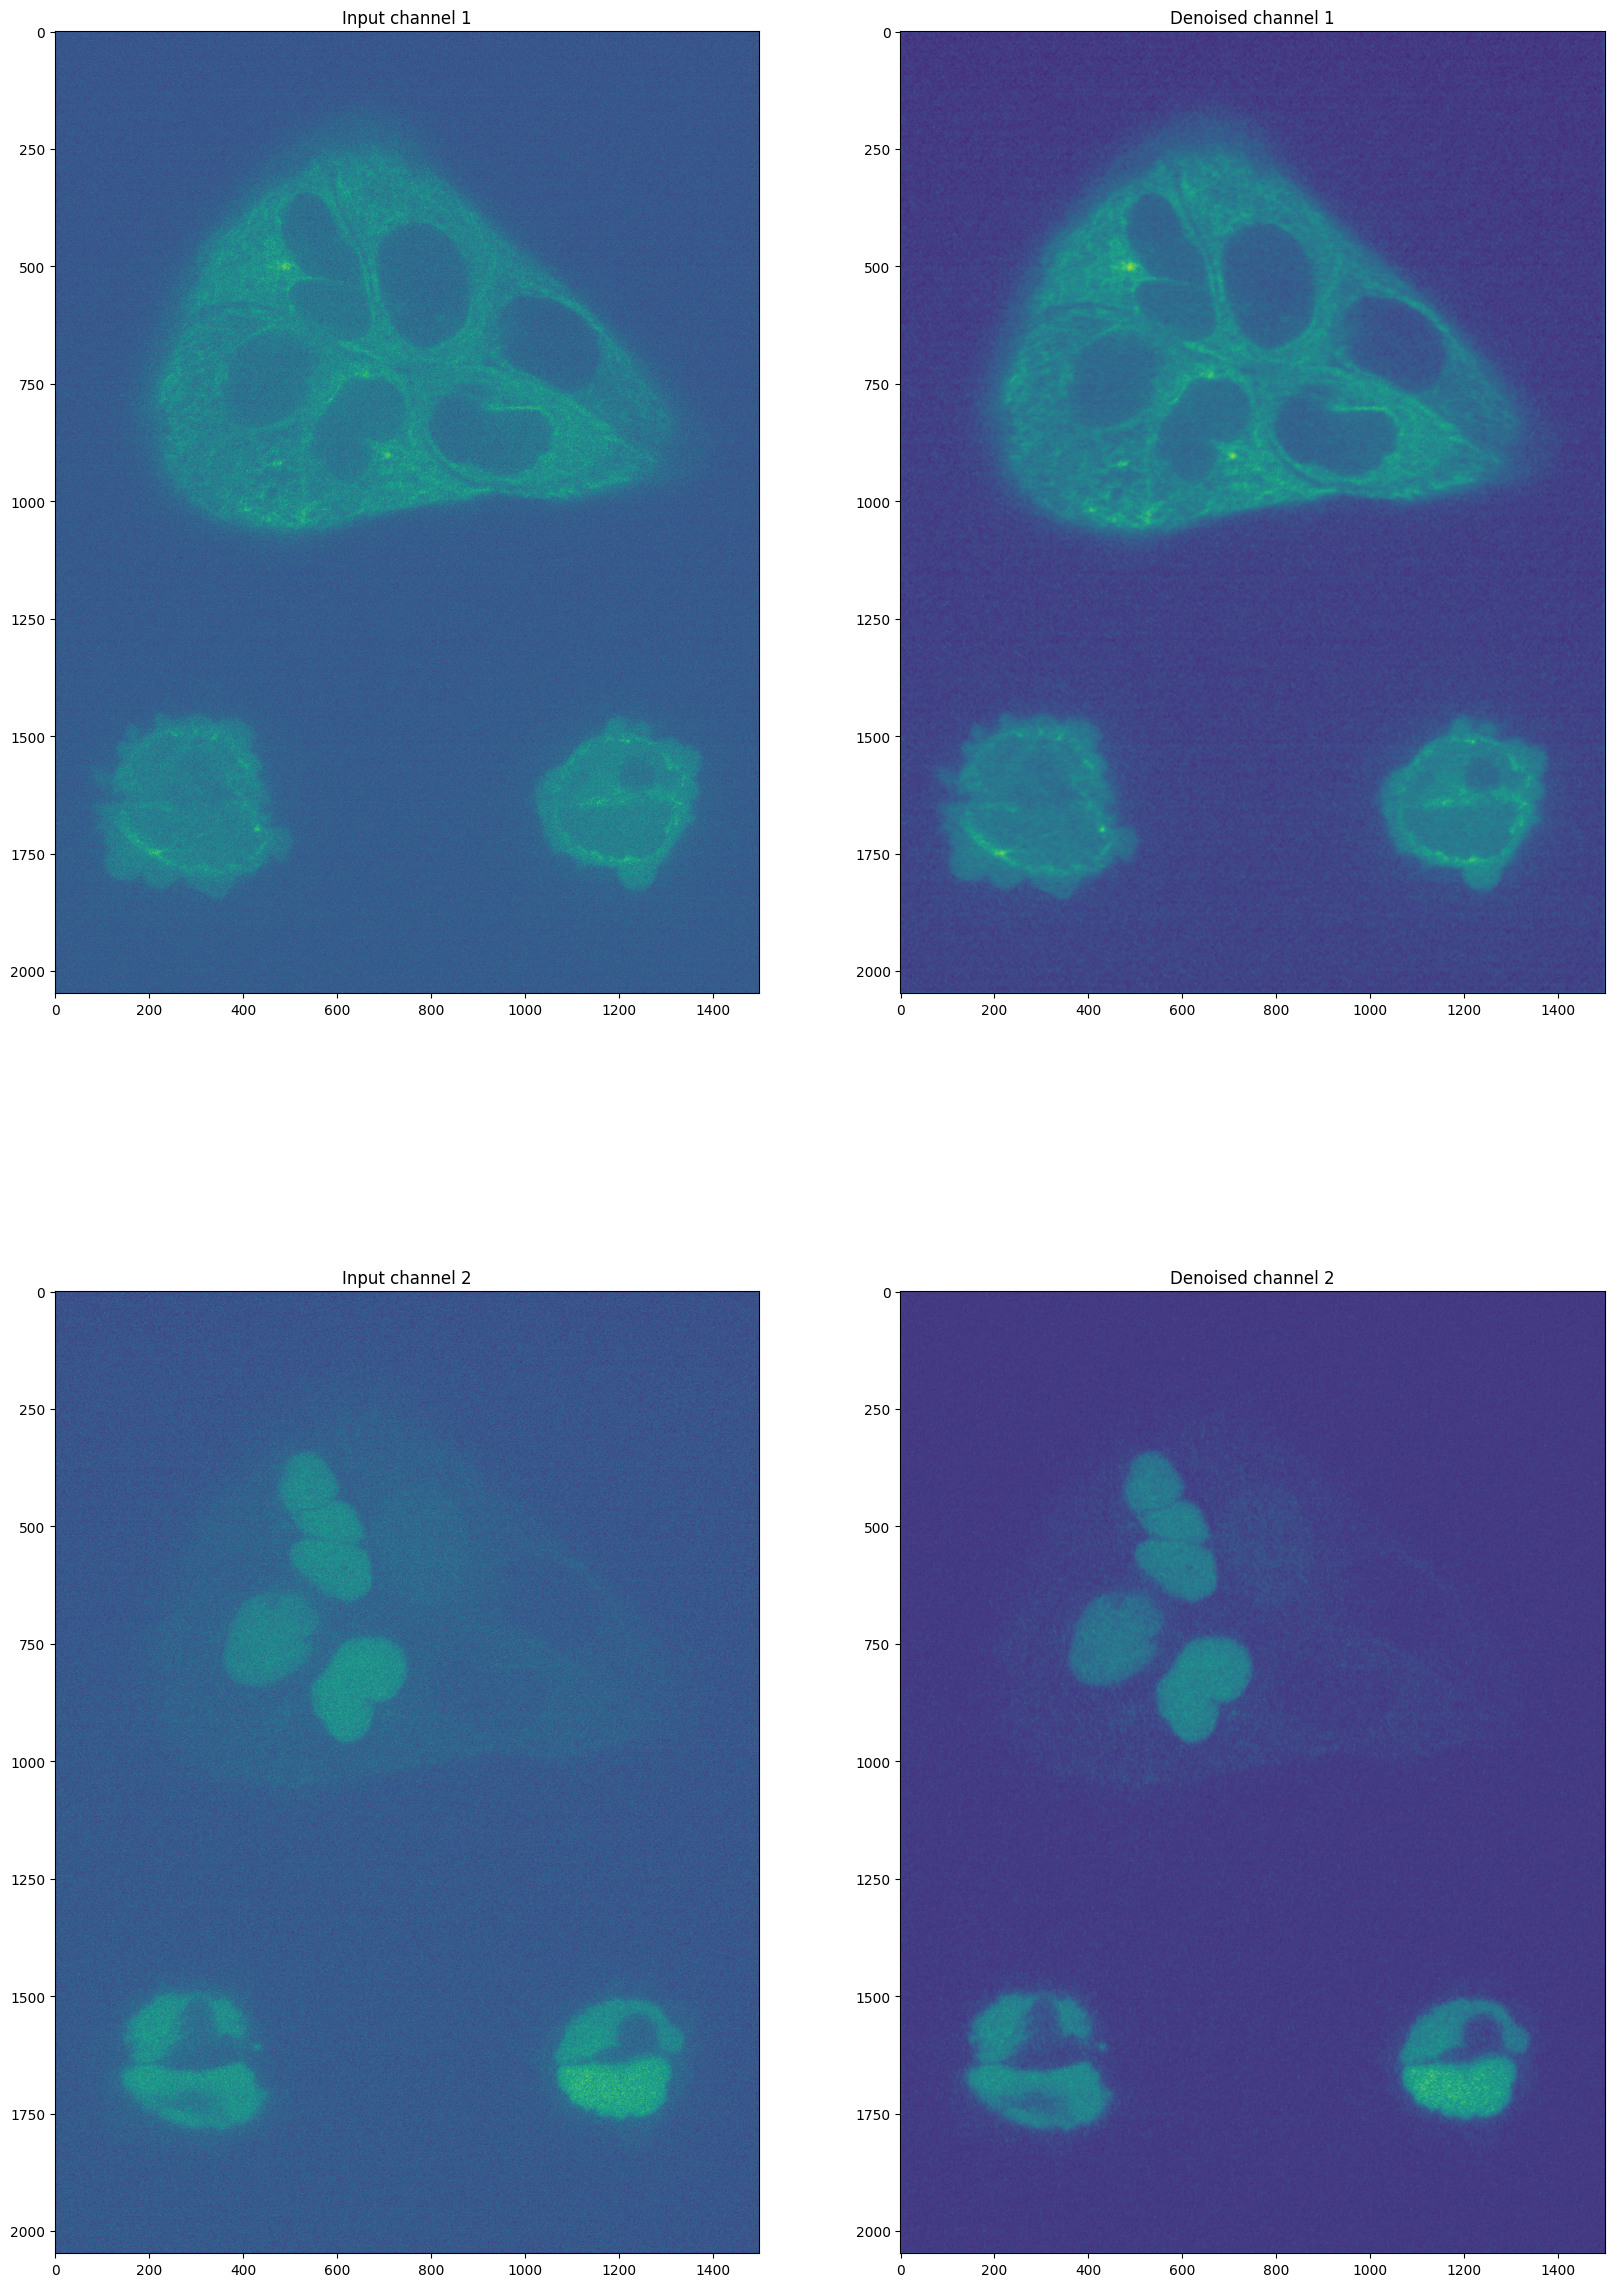

In [16]:
_, ax = plt.subplots(2, 2, figsize=(20, 30))
ax[0][0].imshow(train_data[..., 0])
ax[0][0].set_title("Input channel 1")
ax[0][1].imshow(predicition[0].squeeze()[0])
ax[0][1].set_title("Denoised channel 1")
ax[1][0].imshow(train_data[..., 1])
ax[1][0].set_title("Input channel 2")
ax[1][1].imshow(predicition[0].squeeze()[1])
ax[1][1].set_title("Denoised channel 2")
plt.show()

### Noise model configuration 

In [19]:
noise_model_config = GaussianMixtureNMConfig(model_type="GaussianMixtureNoiseModel",
                                             min_signal=train_data.min(),
                                                max_signal=train_data.max(),
)

### Train the noise model

Here we train a noise model using the denoised images aquired from the N2V model.

We train a separate noise model for each channel.


#### Noise model for channel 1

In [7]:
channel_idx = 0

In [20]:
noise_model = GaussianMixtureNoiseModel(noise_model_config)


[GaussianMixtureNoiseModel] min_sigma: 200.0


In [21]:
noise_model.mode

'train'

In [22]:
noise_model = GaussianMixtureNoiseModel(noise_model_config)
noise_model.train_nm(signal=train_data[..., 0], observation=predicition[0].squeeze()[0])

[GaussianMixtureNoiseModel] min_sigma: 200.0
0 3.8504421710968018
100 3.851905513517927


KeyboardInterrupt: 

### Plot the results

In [23]:
nm_path = "/group/jug/ashesh/training/noise_model/2404/94/GMMNoiseModel_pavia3_sequential_singlefiles-Cond_1__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz"

In [24]:
noise_model_config = GaussianMixtureNMConfig(path=nm_path, model_type="GaussianMixtureNoiseModel")
loaded_noise_model = GaussianMixtureNoiseModel(noise_model_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125


In [25]:
loaded_noise_model.mode

'inference'

{'gmm': {'x': tensor([ 71.7700,  73.3100,  74.8500,  76.3900,  77.9300,  79.4700,  81.0100,
           82.5500,  84.0900,  85.6300,  87.1700,  88.7100,  90.2500,  91.7900,
           93.3300,  94.8700,  96.4100,  97.9500,  99.4900, 101.0300, 102.5700,
          104.1100, 105.6500, 107.1900, 108.7300, 110.2700, 111.8100, 113.3500,
          114.8900, 116.4300, 117.9700, 119.5100, 121.0500, 122.5900, 124.1300,
          125.6700, 127.2100, 128.7500, 130.2900, 131.8300, 133.3700, 134.9100,
          136.4500, 137.9900, 139.5300, 141.0700, 142.6100, 144.1500, 145.6900,
          147.2300, 148.7700, 150.3100, 151.8500, 153.3900, 154.9300, 156.4700,
          158.0100, 159.5500, 161.0900, 162.6300, 164.1700, 165.7100, 167.2500,
          168.7900, 170.3300, 171.8700, 173.4100, 174.9500, 176.4900, 178.0300,
          179.5700, 181.1100, 182.6500, 184.1900, 185.7300, 187.2700, 188.8100,
          190.3500, 191.8900, 193.4300, 194.9700, 196.5100, 198.0500, 199.5900,
          201.1300, 202.6700

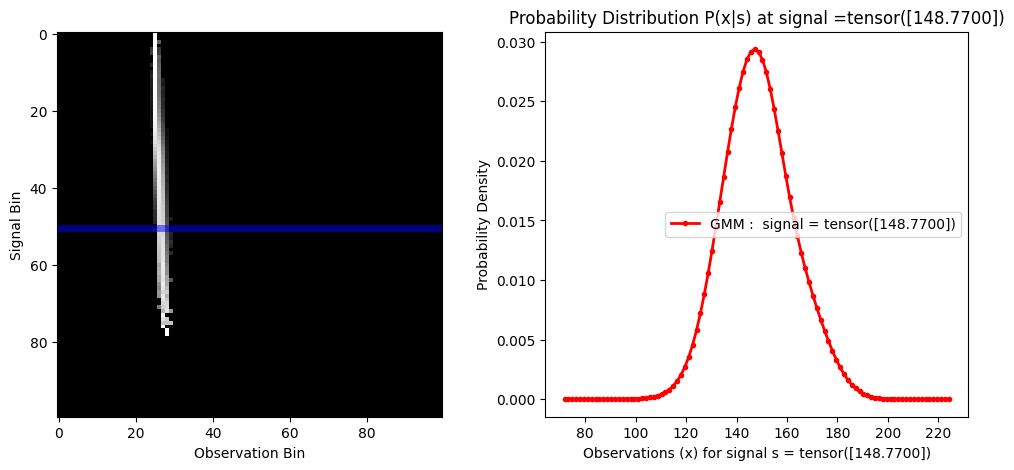

In [28]:
plot_probability_distribution(loaded_noise_model, signalBinIndex=50, histogram=histogram[0])

In [26]:
histogram = create_histogram(bins=100, min_val=train_data.min(), max_val=train_data.max(), signal=train_data[..., 0], observation=predicition[0].squeeze()[0])

{'gmm': {'x': tensor([ 74.7450,  76.2350,  77.7250,  79.2150,  80.7050,  82.1950,  83.6850,
           85.1750,  86.6650,  88.1550,  89.6450,  91.1350,  92.6250,  94.1150,
           95.6050,  97.0950,  98.5850, 100.0750, 101.5650, 103.0550, 104.5450,
          106.0350, 107.5250, 109.0150, 110.5050, 111.9950, 113.4850, 114.9750,
          116.4650, 117.9550, 119.4450, 120.9350, 122.4250, 123.9150, 125.4050,
          126.8950, 128.3850, 129.8750, 131.3650, 132.8550, 134.3450, 135.8350,
          137.3250, 138.8150, 140.3050, 141.7950, 143.2850, 144.7750, 146.2650,
          147.7550, 149.2450, 150.7350, 152.2250, 153.7150, 155.2050, 156.6950,
          158.1850, 159.6750, 161.1650, 162.6550, 164.1450, 165.6350, 167.1250,
          168.6150, 170.1050, 171.5950, 173.0850, 174.5750, 176.0650, 177.5550,
          179.0450, 180.5350, 182.0250, 183.5150, 185.0050, 186.4950, 187.9850,
          189.4750, 190.9650, 192.4550, 193.9450, 195.4350, 196.9250, 198.4150,
          199.9050, 201.3950

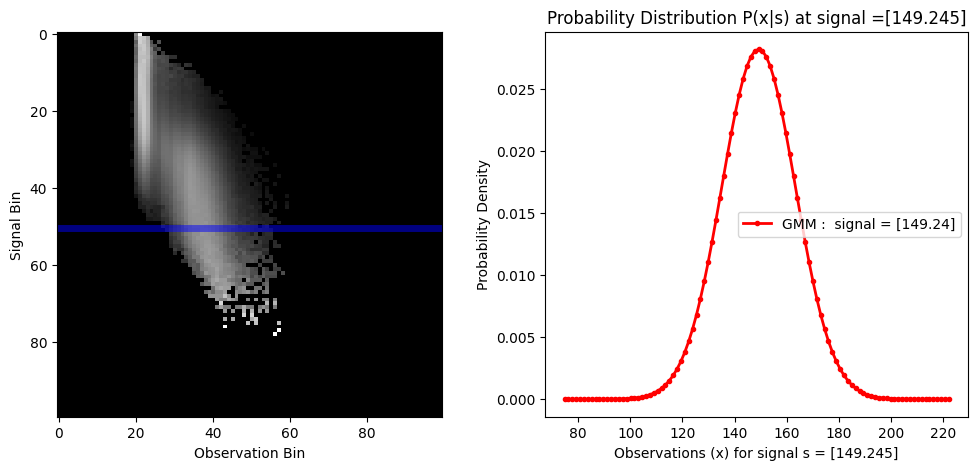

In [53]:
plot_probability_distribution(signalBinIndex=50, histogram=histogram[0])

### Save the noise model

In [ ]:
noise_model.save(noise_model_config.noise_model_path)